In [1]:
#======================================
# Libraries Needed
#======================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd
import re

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# A. Loading the Data
The first part of this project will be to download and view some basic information pertaining to our dataset. This will allow us to have a general idea as to how to move forward with the project as well as understand how the initial data is strucutured. 

In [3]:
#Training Data
train = pd.read_csv('train.csv')
train_labels = pd.read_csv('train_labels.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head() #Test to see if you can read the data

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [5]:
train_labels.head() #Test to see if you can read the data

,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090312455206810_q1,1
3,20090313091715820_q1,0
4,20090313571836404_q1,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      int64  
 1   index           int64  
 2   elapsed_time    int64  
 3   event_name      object 
 4   name            object 
 5   level           int64  
 6   page            float64
 7   room_coor_x     float64
 8   room_coor_y     float64
 9   screen_coor_x   float64
 10  screen_coor_y   float64
 11  hover_duration  float64
 12  text            object 
 13  fqid            object 
 14  room_fqid       object 
 15  text_fqid       object 
 16  fullscreen      int64  
 17  hq              int64  
 18  music           int64  
 19  level_group     object 
dtypes: float64(6), int64(7), object(7)
memory usage: 3.9+ GB


#### Summary of Initial Finding
Even though we have just loaded the data, there are several key features that can be idenitified. These will need to be addressed moving forward and will be vital to the creation of model:
1. As shown by the `train.info()` the dataset that we are using is massive:
    * Before we begin dealing with any type of feature analysis we must reduce the amount of memory used up by our system. 
    * The result of this is to improve the performance of the runtime of our model <br><br>
2. The dataset, while large, consisits of several observations pertaining to the same `session_id`. 
    * This implies that we will need to perform some aggreagation prior to any modeling. 

# B. Reducing Memory Usage of the Dataset
Having now downloaded data, we will make it more manegagble to use by reducing the memory required to process it.

In [7]:
# Function to reduce memory
def reduce_memory(df):   
    for col in df.columns:
        col_type = df[col].dtype.name
        
        #Only focuses on numerical data (categorical data is handled later)
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')): #DateTime object and Category object
            if (col_type != 'object'): #Object type
                col_min = df[col].min()
                col_max = df[col].max()

                #Only focuses on if the type of the attribute is of type 'int'
                # np.iinfo() finds the Machine Limits for the data type
                if str(col_type)[:3] == 'int':
                    #Case 1: If the Machine Limits of the attribute fall between those of type int8
                    if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8) #Changes the type to int8
                    #Case 2: If the Machine Limits of the attribute fall between those of type int16
                    elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16) #Changes the type to int16
                    #Case 3: If the Machine Limits of the attribute fall between those of type int32
                    elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32) #Changes the type to int32
                    #Case 4: If the Machine Limits of the attribute fall between those of type int64
                    elif col_min > np.iinfo(np.int64).min and col_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64) #Changes the type to int64

                #Only focuses on if the type of the attribute is of type 'float'
                # np.finfo() finds the Machine Limits for the data type
                else:
                    #Case 1: If the Machine Limits of the attribute fall between those of type float16
                    if col_min > np.finfo(np.float16).min and col_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    #Case 1: If the Machine Limits of the attribute fall between those of type float32
                    elif col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    #All other cases doesn;t change
                    else:
                        pass
            
            #If the attribute is an object than it will change its type to category
            else:
                df[col] = df[col].astype('category')
    
    return df

In [8]:
train_df = reduce_memory(train)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26296946 entries, 0 to 26296945
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int16   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           int8    
 6   page            float16 
 7   room_coor_x     float16 
 8   room_coor_y     float16 
 9   screen_coor_x   float16 
 10  screen_coor_y   float16 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      int8    
 17  hq              int8    
 18  music           int8    
 19  level_group     category
dtypes: category(7), float16(5), float32(1), int16(1), int32(1), int64(1), int8(4)
memory usage: 1.0 GB


As the above illustrates, we have reduced the amount of memory used from `3.9+ GB` to `1.0 GB`. This is about a 75% decrease! We also will reduce the memory usage of the labels (as shown below).  

In [9]:
labels_df = reduce_memory(train_labels)
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424116 entries, 0 to 424115
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   session_id  424116 non-null  category
 1   correct     424116 non-null  int8    
dtypes: category(1), int8(1)
memory usage: 21.4 MB


In [10]:
labels_df['user_id']=labels_df.session_id.str.split("_", expand = True)[0]

In [11]:
del(train) #saves memory

# C. Preprocessing the Dataset
Having reduced the memory required to download the data, we will now prepocess the data and prepare it for the model.

In [12]:
# Creating a summary of the dataset
def summary(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['data type'])
    summary_df['#missing'] = df.isnull().sum().values * 100      #Calculates the number of missing values
    summary_df['#unique'] = df.nunique().values                  #Caluclates the number of unique values   
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summary_df['min'] = desc['min'].values                       #For numerical data, calculates the min value
    summary_df['max'] = desc['max'].values                       #For numerical data, calulcates the max value
    
    return summary_df #displays summary dataframe

In [13]:
summary_table = summary(train_df)
summary_table

,data type,#missing,#unique,min,max
session_id,int64,0,23562,20090312431273200.0,22100221145014656.0
index,int16,0,20348,0.0,20473.0
elapsed_time,int32,0,5042639,0.0,1988606704.0
event_name,category,0,11,NaN,NaN
name,category,0,6,NaN,NaN
level,int8,0,23,0.0,22.0
page,float16,2573240200,7,0.0,6.0
room_coor_x,float16,207327200,29854,-1992.0,1262.0
room_coor_y,float16,207327200,27847,-918.0,543.5
screen_coor_x,float16,207327200,6866,0.0,1919.0


Using the summary table above, we were able to decide on perform the following tasks to modify our original dataset:
1. We can one-hot encode the attributes `event_name`, `name`, and `room_fqid` to chang ethe categorical data into numerical  

2. Although the attributes `fullscreen`, `hq`, and `music` contain numerical elements, they are categorical attributes in disguise. Therefore, we will also one-hot encode these attributes aswell. 

3. The numerical attributes `elasped_time` and `hover_duration` appear to have outliers (based on the range between min and max values). Therefore, we must remove outliers prioir to the creation ofour model. 

### a. One-Hot Encoding Categorical Variables
The following converts all of the categorical variables listed above (excluding `text` columns) into numerical ones:

In [14]:
#========================================================================
# One-Hot Encoding Categorical Variables
#========================================================================

cat_att = ['event_name', 'name', 'room_fqid', 'fullscreen', 'hq', 'music'] #categorical attributes (from above)

for column in cat_att:
    temp_df = pd.get_dummies(train_df[column], prefix=column)
    
    train_df = pd.merge(
        left = train_df,
        right = temp_df,
        left_index = True,
        right_index = True,
    )
    
train_df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,room_fqid_tunic.kohlcenter.halloffame,room_fqid_tunic.library.frontdesk,room_fqid_tunic.library.microfiche,room_fqid_tunic.wildlife.center,fullscreen_0,fullscreen_1,hq_0,hq_1,music_0,music_1
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,1,0,1,0,0,1
1,20090312431273200,1,1323,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,1,0,1,0,0,1
2,20090312431273200,2,831,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,1,0,1,0,0,1
3,20090312431273200,3,1147,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,1,0,1,0,0,1
4,20090312431273200,4,1863,person_click,basic,0,NaN,-413.0,-159.375,381.0,...,0,0,0,0,1,0,1,0,0,1


In [15]:
# Getting shape of the df
shape = train_df.shape
  
# Printing Number of columns
print('Number of columns :', shape[1])

Number of columns : 62


In [16]:
#dropping the unnessary attributes
train_df = train_df.drop(columns = cat_att, axis = 1)

In [17]:
# Getting shape of the df
shape = train_df.shape
  
# Printing Number of columns
print('Number of columns :', shape[1])

Number of columns : 56


Having changed some initial categorical attributes into numerical ones, we will address the outliers.

### b. Handling Outliers (Winzorization Method)
To handle the following outliers, we will cap the data values that pertain to the numerical attributes. By capping the data values, we maintain the same number of observations while still dealing with outliers. Our caps will be at the 5th percentile and 95th percentile. 

In [18]:
#===================================================================
# Confirming Outliers
#===================================================================

num_attr = ['elapsed_time', 'hover_duration'] #numerical attributes listed above

def CountOutliers(attributes):
    num_outliers = 0
    
    for col in attributes:
        #Finds some Summary Statistics
        Q1 = train_df[col].quantile(0.25)
        Q3 = train_df[col].quantile(0.75)
        IQR = Q3 - Q1
    
        num_outliers = ((train_df[col]<(Q1-1.5*IQR)) | (train_df[col]>(Q3+1.5*IQR))).sum()
    
        print("There are "+ str(num_outliers) + " outliers in the " + col + " column.")
        
CountOutliers(num_attr) #Test

#Sets up a zoomed in version of the boxplot
# plt.rcParams["figure.figsize"] = [16.0, 4.0] #sets the graph sizes
# plt.xlim(0,4000000) #Displays a zoomed in version of the boxplot
# train_df.boxplot(column= 'elapsed_time', return_type='axes',vert = False) #elasped Time

There are 1905440 outliers in the elapsed_time column.
There are 282683 outliers in the hover_duration column.


In [56]:
from scipy.stats.mstats import winsorize #library neeeded
#========================================================================================
# Removing Outliers
#========================================================================================

# Winzorization Method resticts the data of elasped_time column up to the 90% percentile
train_df['elapsed_time_winsr'] = winsorize(train_df['elapsed_time'], limits=[None, 0.09]) #elasped time

# Winzorization Method resticts the data of elasped_time column up to the 85% percentile
mask = ~train_df['hover_duration'].isna() #displays which elements are NaN in the hover_duration column
train_df.loc[mask, 'hover_duration_winsr'] = winsorize(train_df['hover_duration'].loc[mask], limits=[None, 0.15])

In [57]:
num_attr = ['elapsed_time_winsr', 'hover_duration_winsr']
CountOutliers(num_attr) #Test

There are 0 outliers in the elapsed_time_winsr column.
There are 0 outliers in the hover_duration_winsr column.


<AxesSubplot:>

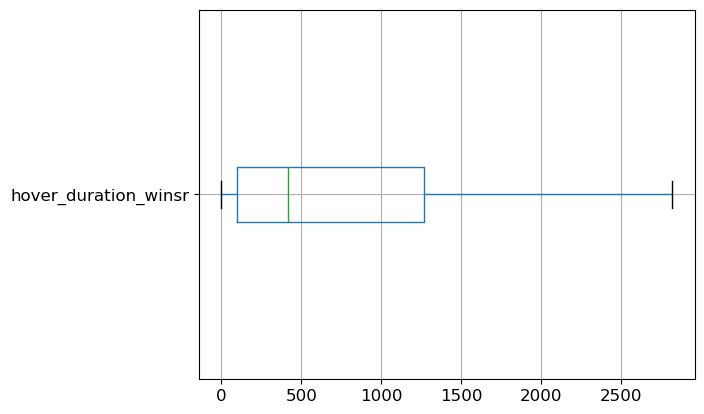

In [58]:
train_df.boxplot(column= 'hover_duration_winsr', return_type='axes', vert = False)

<AxesSubplot:>

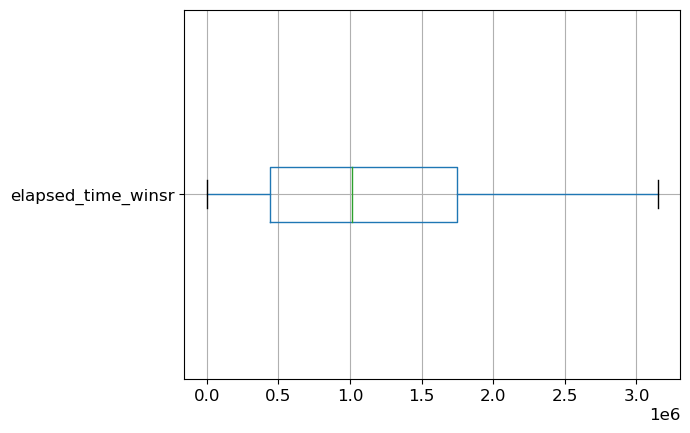

In [60]:
train_df.boxplot(column= 'elapsed_time_winsr', return_type='axes', vert = False)

In [61]:
#Drops the unnecessary columns
train_df = train_df.drop(columns = ['elapsed_time', 'hover_duration'], axis = 1)

In [62]:
train_df.head()

,session_id,index,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,text,fqid,...,room_fqid_tunic.library.microfiche,room_fqid_tunic.wildlife.center,fullscreen_0,fullscreen_1,hq_0,hq_1,music_0,music_1,elapsed_time_winsr,hover_duration_winsr
0,20090312431273200,0,0,NaN,-414.0,-159.375,380.0,494.0,undefined,intro,...,0,0,1,0,1,0,0,1,0,NaN
1,20090312431273200,1,0,NaN,-414.0,-159.375,380.0,494.0,"Whatcha doing over there, Jo?",gramps,...,0,0,1,0,1,0,0,1,1323,NaN
2,20090312431273200,2,0,NaN,-414.0,-159.375,380.0,494.0,Just talking to Teddy.,gramps,...,0,0,1,0,1,0,0,1,831,NaN
3,20090312431273200,3,0,NaN,-414.0,-159.375,380.0,494.0,I gotta run to my meeting!,gramps,...,0,0,1,0,1,0,0,1,1147,NaN
4,20090312431273200,4,0,NaN,-413.0,-159.375,381.0,494.0,"Can I come, Gramps?",gramps,...,0,0,1,0,1,0,0,1,1863,NaN


### c. Modifying the Text Data
As `train_df` shows, there is an attribute called `text`. We believe that the text that is played at each observation (if applicable) is important. We assume that particular responses are choosen depending on whether or not the player was able to correctly answer the question. Therefore, prior to any model selection, we must first perform some text mining and language processing. 

# STILL NEED TO FINISH THIS SECTION THEN OFF TO FEATURE SELECTION WITH RANDOM FORREST

In [35]:
type(train_df['room_coor_x'])
type(train_df['elapsed'])

pandas.core.series.Series

In [32]:
type(winsorize(train_df['elapsed_time'], limits=[None, 0.05]))

numpy.ma.core.MaskedArray

In [ ]:
df2 = pd.DataFrame(d2)

In [ ]:
for col in df:
    print(df[col].unique())

In [47]:
print(train_df['name'].unique())

['basic', 'undefined', 'close', 'open', 'prev', 'next']
Categories (6, object): ['basic', 'undefined', 'close', 'open', 'prev', 'next']


In [48]:
print(train_df['text'].unique())

['undefined', 'Whatcha doing over there, Jo?', 'Just talking to Teddy.', 'I gotta run to my meeting!', 'Can I come, Gramps?', ..., 'Come on, Jo!', 'Meet me back in my office and we'll get start..., 'Here I am!', 'Wells sabotaged Gramps!', 'AND he stole Teddy!']
Length: 598
Categories (597, object): ['undefined', 'Whatcha doing over there, Jo?', 'Just talking to Teddy.', 'I gotta run to my meeting!', ..., 'Meet me back in my office and we'll get start..., 'Here I am!', 'Wells sabotaged Gramps!', 'AND he stole Teddy!']


In [61]:
l = train_df['text_fqid'].unique()

In [62]:
for i in l:
    print(i)

tunic.historicalsociety.closet.intro
tunic.historicalsociety.closet.gramps.intro_0_cs_0
tunic.historicalsociety.closet.teddy.intro_0_cs_0
nan
tunic.historicalsociety.closet.teddy.intro_0_cs_5
tunic.historicalsociety.closet.photo
tunic.historicalsociety.closet.notebook
tunic.historicalsociety.closet.retirement_letter.hub
tunic.historicalsociety.basement.janitor
tunic.historicalsociety.entry.groupconvo
tunic.historicalsociety.entry.boss.talktogramps
tunic.historicalsociety.entry.wells.talktogramps
tunic.historicalsociety.collection.cs
tunic.historicalsociety.collection.tunic.slip
tunic.historicalsociety.collection.gramps.found
tunic.historicalsociety.stacks.outtolunch
tunic.kohlcenter.halloffame.plaque.face.date
tunic.kohlcenter.halloffame.togrampa
tunic.capitol_0.hall.boss.talktogramps
tunic.historicalsociety.closet_dirty.what_happened
tunic.historicalsociety.closet_dirty.gramps.helpclean
tunic.historicalsociety.closet_dirty.trigger_scarf
tunic.historicalsociety.closet_dirty.trigger_cof

In [64]:
m = train_df['text'].unique()
for i in m:
    print(i)

undefined
Whatcha doing over there, Jo?
Just talking to Teddy.
I gotta run to my meeting!
Can I come, Gramps?
Sure thing, Jo. Grab your notebook and come upstairs!
See you later, Teddy.
I get to go to Gramps's meeting!
Now where did I put my notebook?
\u00f0\u0178\u02dc\u00b4
nan
I love these photos of me and Teddy!
Found it!
Gramps is in trouble for losing papers?
This can't be right!
Gramps is a great historian!
Hmm. Button's still not working.
Let's get started. The Wisconsin Wonders exhibit opens tomorrow!
Who wants to investigate the shirt artifact?
Not Leopold here. He's been losing papers lately.
Hey!
It's true, they do keep going missing lately.
See?
Besides, I already figured out the shirt.
It's a women's basketball jersey!
That settles it.
Wells, finish up your report.
Leopold, why don't you help me set up in the Capitol?
We need to talk about that missing paperwork.
Will do, Boss.
Hey Jo, let's take a look at the shirt!
Your grampa is waiting for you in the collection room.


In [17]:
labels_df.head()

,session_id,correct,user_id
0,20090312431273200_q1,1,20090312431273200
1,20090312433251036_q1,0,20090312433251036
2,20090312455206810_q1,1,20090312455206810
3,20090313091715820_q1,0,20090313091715820
4,20090313571836404_q1,1,20090313571836404


In [20]:
labels_df["level"] = labels_df.session_id.str.split("_", expand = True)[1]
labels_df["level"] = labels_df["level"].apply(lambda x : re.sub("\D", "",x)) 
labels_df["level"] = pd.to_numeric(labels_df["level"])
labels_df["user_id"] = pd.to_numeric(labels_df["user_id"])
labels_df["session_level"] = labels_df["level"].apply(lambda x: 0 if x <= 4 else 1 if x >= 5 and x <= 12 else 2)

In [21]:
labels_df.head()

,session_id,correct,user_id,level,session_level
0,20090312431273200_q1,1,20090312431273200,1,0
1,20090312433251036_q1,0,20090312433251036,1,0
2,20090312455206810_q1,1,20090312455206810,1,0
3,20090313091715820_q1,0,20090313091715820,1,0
4,20090313571836404_q1,1,20090313571836404,1,0


In [22]:
# Questions 1-4 belong to level 1, 5-12 to level 2, 13 - 22 to level 3
labels_df.level.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18], dtype=int64)

In [23]:
print("Number of unique users: ",len(labels_df.user_id.unique()))
print("Number of unique sessions: ",len(labels_df.session_id.unique()))

Number of unique users:  23562
Number of unique sessions:  424116


In [24]:
train_df.isnull().sum()

session_id               0
index                    0
elapsed_time             0
event_name               0
name                     0
level                    0
page              25732402
room_coor_x        2073272
room_coor_y        2073272
screen_coor_x      2073272
screen_coor_y      2073272
hover_duration    24294702
text              16679807
fqid               8274415
room_fqid                0
text_fqid         16679702
fullscreen               0
hq                       0
music                    0
level_group              0
dtype: int64

In [25]:
numeric_feature_names = ['session_id', 'index', 'elapsed_time', 'level',
       'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'fullscreen', 'hq', 'music']
numeric_features = train_df[numeric_feature_names].copy()
numeric_features.head()

,session_id,index,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music
0,20090312431273200,0,0,0,NaN,-414.0,-159.375,380.0,494.0,NaN,0,0,1
1,20090312431273200,1,1323,0,NaN,-414.0,-159.375,380.0,494.0,NaN,0,0,1
2,20090312431273200,2,831,0,NaN,-414.0,-159.375,380.0,494.0,NaN,0,0,1
3,20090312431273200,3,1147,0,NaN,-414.0,-159.375,380.0,494.0,NaN,0,0,1
4,20090312431273200,4,1863,0,NaN,-413.0,-159.375,381.0,494.0,NaN,0,0,1


In [26]:
# Based on the data described in the notebook, this is an MNAR type, meaning, the value is missing not at random 
numeric_features.isnull().sum()

session_id               0
index                    0
elapsed_time             0
level                    0
page              25732402
room_coor_x        2073272
room_coor_y        2073272
screen_coor_x      2073272
screen_coor_y      2073272
hover_duration    24294702
fullscreen               0
hq                       0
music                    0
dtype: int64

In [27]:
numeric_features.shape,labels_df.shape

((26296946, 13), (424116, 5))

In [29]:
len(numeric_features['session_id'].unique()),len(train_labels['user_id'].unique())

(23562, 23562)

In [30]:
numeric_features['hover_duration'].describe()

count    2.002244e+06
mean     3.461647e+03
std      4.601901e+05
min      0.000000e+00
25%      9.900000e+01
50%      4.190000e+02
75%      1.266000e+03
max      2.451637e+08
Name: hover_duration, dtype: float64

In [32]:
# Creating a copy of my labels so I can modify the column names and keep the raw dataset intact
labels_df_cp= labels_df.copy()
labels_df_cp.rename(columns = {'session_id':'session_res','user_id':'session_id'}, inplace = True)
labels_df_cp.head()
# There is no level 0 in the training labels provided, how should we handle this?
train_df_cp = train_df.copy()
df_full = pd.merge(train_df_cp, labels_df_cp, how='inner',on=['session_id','level'])
df_full.head()
df_full.shape

(20732578, 23)

In [33]:
scaler = MinMaxScaler()
scaler.fit(df_full[['elapsed_time', 'fullscreen','room_coor_x','room_coor_y','screen_coor_x',
                    'screen_coor_y','hover_duration']])
training_data_scaled = scaler.transform(df_full[['elapsed_time', 'fullscreen','room_coor_x','room_coor_y','screen_coor_x',
                                                 'screen_coor_y','hover_duration']])
training_data_scaled = pd.DataFrame(df_full, columns=['elapsed_time_scaled', 'fullscreen_scaled','room_coor_x_scaled',
                                                      'room_coor_y_scaled','screen_coor_x_scaled','screen_coor_y_scaled',
                                                      'hover_duration_scaled'])
df_full = pd.concat([df_full, training_data_scaled], axis=1)
print('Dataset shape: ',df_full.shape,'\n')
df_full.head()

Dataset shape:  (20732578, 30) 



,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,session_res,correct,session_level,elapsed_time_scaled,fullscreen_scaled,room_coor_x_scaled,room_coor_y_scaled,screen_coor_x_scaled,screen_coor_y_scaled,hover_duration_scaled
0,20090312431273200,28,28113,navigate_click,undefined,1,NaN,-587.5,-27.921875,441.0,...,20090312431273200_q1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20090312431273200,29,32229,notification_click,basic,1,NaN,-182.5,-1.906250,767.0,...,20090312431273200_q1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20090312431273200,30,33063,notification_click,basic,1,NaN,-182.5,-55.875000,767.0,...,20090312431273200_q1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20090312431273200,31,34245,notification_click,basic,1,NaN,-182.5,-55.875000,767.0,...,20090312431273200_q1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20090312431273200,32,36433,object_click,close,1,NaN,-113.5,241.125000,836.0,...,20090312431273200_q1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
training_data=df_full[['elapsed_time_scaled','fullscreen_scaled']]
label_data=df_full[['correct']]
print('Training data shape: ',training_data.shape,'\n','Label data shape: ',label_data.shape)
x_train,x_val = training_data[:int(len(training_data)*.8)],training_data[int(len(training_data)*.8):]
y_train,y_val = label_data[:int(len(label_data)*.8)],label_data[int(len(label_data)*.8):]
print('X train shape: ',x_train.shape,'\n','X valid shape: ',x_val.shape)
model = keras.models.Sequential([
    keras.layers.Dense(10, input_shape=(2,),activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

Training data shape:  (20732578, 2) 
 Label data shape:  (20732578, 1)
X train shape:  (16586062, 2) 
 X valid shape:  (4146516, 2)


In [35]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [36]:
history = model.fit(x_train, y_train, epochs=5,
                    validation_data=(x_val, y_val))

Epoch 1/5
518315/518315 [==============================] - 6777s 13ms/step - loss: nan - accuracy: 0.2844 - val_loss: nan - val_accuracy: 0.2736
Epoch 2/5
 43493/518315 [=>............................] - ETA: 11:03 - loss: nan - accuracy: 0.2849

KeyboardInterrupt: 